In [1]:
import pandas as pd
import numpy as np
import scipy.io
import h5py
import mne
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression


### Examining the structures inside the EEG_full

In [2]:
# Load the .mat file
file_path = "/kaggle/input/arousal/S01_C_OLoop.mat"  # Update with correct path
mat_data = h5py.File(file_path, 'r')

# Check if 'actualVariable' exists
if 'actualVariable' in mat_data:
    actual_var = mat_data['actualVariable']
    print("Keys inside actualVariable:", list(actual_var.keys()))
    
    # Check if 'EEG_full' exists inside 'actualVariable'
    if 'EEG_full' in actual_var:
        eeg_full = actual_var['EEG_full']
        print("Keys inside EEG_full:", list(eeg_full.keys()))
    else:
        print("'EEG_full' not found inside 'actualVariable'")
else:
    print("'actualVariable' not found in the dataset")


Keys inside actualVariable: ['EEG_full']
Keys inside EEG_full: ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate', 'stats', 'subject', 'times', 'trials', 'urchanlocs', 'urevent', 'xmax', 'xmin']


### Examining the chaninfo

In [3]:
if 'chaninfo' in eeg_full:
    eeg_data = eeg_full['chaninfo']
    print("Keys inside chaninfo:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chaninfo: ['filecontent', 'filename', 'icachansind', 'nodatchans', 'nosedir', 'plotrad', 'shrink']


### Examining chanlocs

In [4]:
if 'chanlocs' in eeg_full:
    eeg_data = eeg_full['chanlocs']
    print("Keys inside chanlocs:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chanlocs: ['X', 'Y', 'Z', 'labels', 'radius', 'ref', 'sph_phi', 'sph_radius', 'sph_theta', 'theta', 'type', 'urchan']


### Combining the chanlocs

In [5]:
# Extract channel labels
channel_labels = []

chanlocs = eeg_full['chanlocs']

for ref in chanlocs['labels']:
    obj = mat_data[ref[0]]  # Dereference
    label = ''.join(map(chr, obj[:].flatten()))  # Convert to string
    channel_labels.append(label)

def extract_data(ref_array):
    """Extracts numeric data from HDF5 references, ensuring uniform shape."""
    values = []
    
    for ref in ref_array:
        obj = mat_data[ref[0]]  # Dereference
        
        data = obj[()]  # Extract value(s)
        if isinstance(data, np.ndarray):  
            data = data.flatten()  # Ensure it's 1D
            if data.size == 1:
                values.append(data[0])  # Append single value
            else:
                values.append(list(data))  # Append list if multiple values
        else:
            values.append(data)  # Append scalar directly
    
    return values  # Return list instead of NumPy array

# Convert fields into lists of numerical values
df_chanlocs = pd.DataFrame({
    "Channel": channel_labels,
    "X": extract_data(chanlocs['X']),
    "Y": extract_data(chanlocs['Y']),
    "Z": extract_data(chanlocs['Z']),
    "Theta": extract_data(chanlocs['theta']),
    "Sph_Phi": extract_data(chanlocs['sph_phi']),
    "Sph_Theta": extract_data(chanlocs['sph_theta']),
    "Sph_Radius": extract_data(chanlocs['sph_radius'])
})

print(channel_labels)

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'ECG', 'HR', 'HR-delta', 'HR-delta-abs', 'HRV-pNN35', 'RESP', 'EDA', 'EDAz', 'EDA-phasic', 'EDA-SMNA', 'EDA-tonic', 'PUP-L', 'PUP-R', 'PORX', 'PORY', 'PORX-L', 'PORY-L', 'PORX-R', 'PORY-R', 'EYE-Time', 'EYE-Validity', 'PUP-int-L', 'PUP-int-R', 'PORX-int', 'PORY-int', 'PORX-int-L', 'PORY-int-L', 'PORX-int-R', 'PORY-int-R', 'PUP-conv05-4-L', 'PUP-conv05-4-R', 'PUP-logbp06-L', 'PUP-logbp06-R', 'Sac-Amp-Avg', 'Sac-Angle-Abs-Avg', 'Sac-Dur-Avg', 'Sac-VMax-Avg', 'Fix-Dur-Avg', 'Sac-rate-pmin', 'Fix-rate-pmin', 'Blink-rate-pmin', 'Joy-Pitch', 'Joy-Roll', 'Joy-Pitch-acc', 'Joy-Roll-ac

In [6]:
with h5py.File(file_path, "r") as f:
                # Navigate through the structure
                actual_variable = f["actualVariable"]
                eeg_full = actual_variable["EEG_full"]
                data = eeg_full["times"]
                
                # Convert to NumPy array
                data_array = np.array(data)
                
                df = pd.DataFrame(data_array)                
                print(df)

                   0
0            0.00000
1            3.90625
2            7.81250
3           11.71875
4           15.62500
...              ...
139531  545042.96875
139532  545046.87500
139533  545050.78125
139534  545054.68750
139535  545058.59375

[139536 rows x 1 columns]


### Electrode placement

In [7]:
# Keep only rows where X, Y, Z are numbers (filter out metadata)
df_cleaned = df_chanlocs[df_chanlocs["X"].apply(lambda x: isinstance(x, float))]

df_cleaned


Channel         X         Y         Z  Theta Sph_Phi Sph_Theta Sph_Radius
0      Fp1  0.950477  0.308829 -0.034899  -18.0    -2.0      18.0        1.0
1      AF7  0.787531  0.615286 -0.034899  -38.0    -2.0      38.0        1.0
2      AF3  0.884846  0.375595  0.275637  -23.0    16.0      23.0        1.0
3       F1  0.710264  0.286965  0.642788  -22.0    40.0      22.0        1.0
4       F3  0.673028  0.545007       0.5  -39.0    30.0      39.0        1.0
..     ...       ...       ...       ...    ...     ...       ...        ...
59      P8 -0.587427 -0.808524 -0.034899  126.0    -2.0    -126.0        1.0
60     P10 -0.532714 -0.733218 -0.422618  126.0   -25.0    -126.0        1.0
61     PO8 -0.808524 -0.587427 -0.034899  144.0    -2.0    -144.0        1.0
62     PO4 -0.884846 -0.375595  0.275637  157.0    16.0    -157.0        1.0
63      O2 -0.950477 -0.308829 -0.034899  162.0    -2.0    -162.0        1.0

[64 rows x 8 columns]

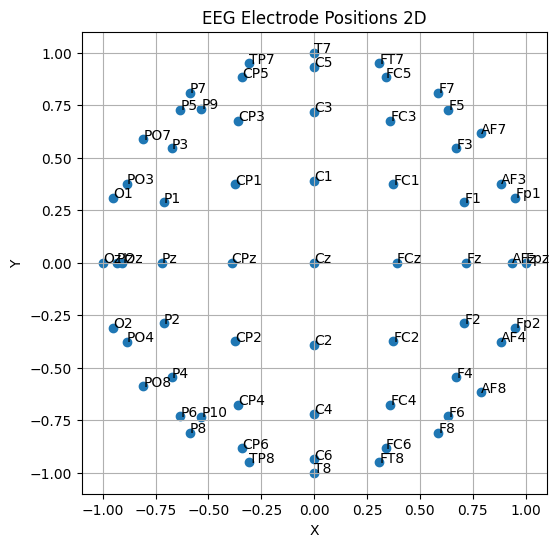

In [8]:
# Plot the electrode positions
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_cleaned['X'], df_cleaned['Y'], label='Electrodes')

for i, label in enumerate(df_cleaned['Channel']):
    ax.annotate(label, (df_cleaned['X'][i], df_cleaned['Y'][i]))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('EEG Electrode Positions 2D')
plt.grid(True)
plt.savefig("channel_positions.png")
plt.show()


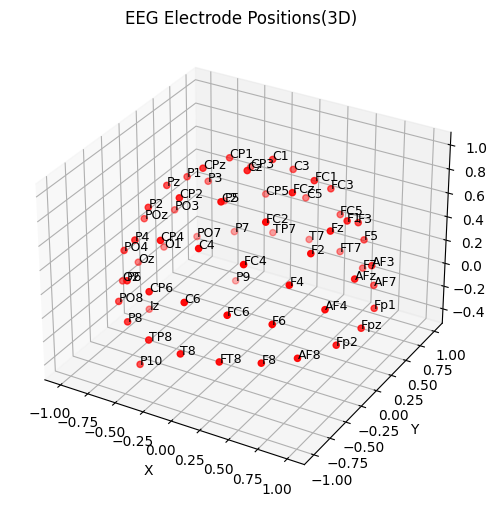

In [9]:
# Visualizing electrode placement



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract valid coordinates
x, y, z = df_cleaned["X"], df_cleaned["Y"], df_cleaned["Z"]

# Scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Label the points
for i, channel in enumerate(df_cleaned["Channel"]):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], channel, fontsize=9)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("EEG Electrode Positions(3D)")
plt.savefig("3d_channel_positions.png")
plt.show()


### Checking the labels

In [10]:
# labels = extract_data(eeg_full['chanlocs']['labels'])
# pd.DataFrame(labels)

### Obtaining the data

In [11]:
if 'data' in eeg_full:
    eeg_data = eeg_full['data']
    eeg_data = pd.DataFrame(eeg_data)
    eeg_data

### Converting the data to a pandas dataframe

In [12]:

# Assign column names
eeg_data.columns = channel_labels

# Display the first few rows
x = type(eeg_data)
print(x)

<class 'h5py._hl.group.Group'>


In [13]:
import pandas as pd
import numpy as np
import os
import h5py
from sklearn.preprocessing import StandardScaler

def preprocess_eeg(data_array, channel_labels):
    print("Starting EEG preprocessing")
    df = pd.DataFrame(data_array, columns=channel_labels)

    # Drop non-EEG columns
    non_eeg_columns = ['Head-x', 'Head-y', 'Head-z', 'Condition', 'Flight-time', 'Course-type', 'FB-type', 'Ring-type', 'LSL-time']
    eeg_columns = [col for col in df.columns if col not in non_eeg_columns]
    df = df[eeg_columns]

    # Handle missing values properly
    print("Filling in missing values")
    df = df.ffill().bfill().dropna(axis=1)
    eeg_columns = df.columns
    print("Columns adjusted, proceeding to scaling")
    
    # Standardize EEG signals safely
    scaler = StandardScaler()
    df[eeg_columns] = df[eeg_columns].map(lambda x: x + 1e-8 if x == 0 else x)  # Add epsilon only where necessary
    df[eeg_columns] = scaler.fit_transform(df[eeg_columns]).astype(np.float32)  # Reduce precision to float32
    print("Scaling completed")

    return df

def process_mat_file(input_folder, output_folder, subject_number, file_prefix):
    mat_file = f"S{subject_number:02d}_{file_prefix}.mat"
    mat_file_path = os.path.join(input_folder, mat_file)

    csv_file_path = os.path.join(output_folder, f"S{subject_number:02d}_{file_prefix}_preprocessed.csv")

    if os.path.exists(csv_file_path):
        print(f"Skipping {csv_file_path} (already processed)")
        return

    if os.path.exists(mat_file_path):
        print(f"Processing file: {mat_file_path}")
        with h5py.File(mat_file_path, "r") as f:
            actual_variable = f["actualVariable"]
            eeg_full = actual_variable["EEG_full"]
            data = eeg_full["data"]
            data_array = np.array(data)
            
            print(f"Data shape for subject {subject_number}: {data_array.shape}")  # Debugging print
            
            df = preprocess_eeg(data_array, channel_labels)
            
            if df is None or df.empty:
                print(f"Skipping subject {subject_number} due to empty DataFrame.")
                return  # Skip this subject
            
            df.to_csv(csv_file_path, index=False, float_format='%.6f')  # Reduce file size with lower precision
            print(f"Processed and saved: {csv_file_path}")

# Define folder paths
input_folder = "/kaggle/input/arousal"
output_folder_C_OLoop = "csv_C_OLoop_preprocessed"
output_folder_F_CL_Sil_50_100 = "csv_F_CL_Sil_50_100_preprocessed"

# Ensure output directories exist
os.makedirs(output_folder_C_OLoop, exist_ok=True)
os.makedirs(output_folder_F_CL_Sil_50_100, exist_ok=True)

# Process each subject (1-18)
for subject_number in range(1, 19):
    print(f"\n--- Processing Subject {subject_number} ---")

    # Process and save F_CL_Sil_50_100 files in its folder
    process_mat_file(input_folder, output_folder_F_CL_Sil_50_100, subject_number, "F_CL_Sil_50_100")

    # Process and save C_OLoop files in its folder
    process_mat_file(input_folder, output_folder_C_OLoop, subject_number, "C_OLoop")

print("\n✅ All participants' data has been processed successfully and saved in separate folders.")



--- Processing Subject 1 ---
Processing file: /kaggle/input/arousal/S01_F_CL_Sil_50_100.mat
Data shape for subject 1: (441421, 144)
Starting EEG preprocessing
Filling in missing values
Columns adjusted, proceeding to scaling
Scaling completed
Processed and saved: csv_F_CL_Sil_50_100_preprocessed/S01_F_CL_Sil_50_100_preprocessed.csv
Processing file: /kaggle/input/arousal/S01_C_OLoop.mat
Data shape for subject 1: (139536, 144)
Starting EEG preprocessing
Filling in missing values
Columns adjusted, proceeding to scaling
Scaling completed
Processed and saved: csv_C_OLoop_preprocessed/S01_C_OLoop_preprocessed.csv

--- Processing Subject 2 ---
Processing file: /kaggle/input/arousal/S02_F_CL_Sil_50_100.mat
Data shape for subject 2: (249276, 144)
Starting EEG preprocessing
Filling in missing values
Columns adjusted, proceeding to scaling
Scaling completed
Processed and saved: csv_F_CL_Sil_50_100_preprocessed/S02_F_CL_Sil_50_100_preprocessed.csv
Processing file: /kaggle/input/arousal/S02_C_OLoo

In [14]:
df

0
0            0.00000
1            3.90625
2            7.81250
3           11.71875
4           15.62500
...              ...
139531  545042.96875
139532  545046.87500
139533  545050.78125
139534  545054.68750
139535  545058.59375

[139536 rows x 1 columns]

In [15]:
df_open = pd.read_csv("/kaggle/working/csv_C_OLoop_preprocessed/S01_C_OLoop_preprocessed.csv")
df_closed = pd.read_csv("/kaggle/working/csv_F_CL_Sil_50_100_preprocessed/S01_F_CL_Sil_50_100_preprocessed.csv")

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Show only columns with missing values


Series([], dtype: int64)


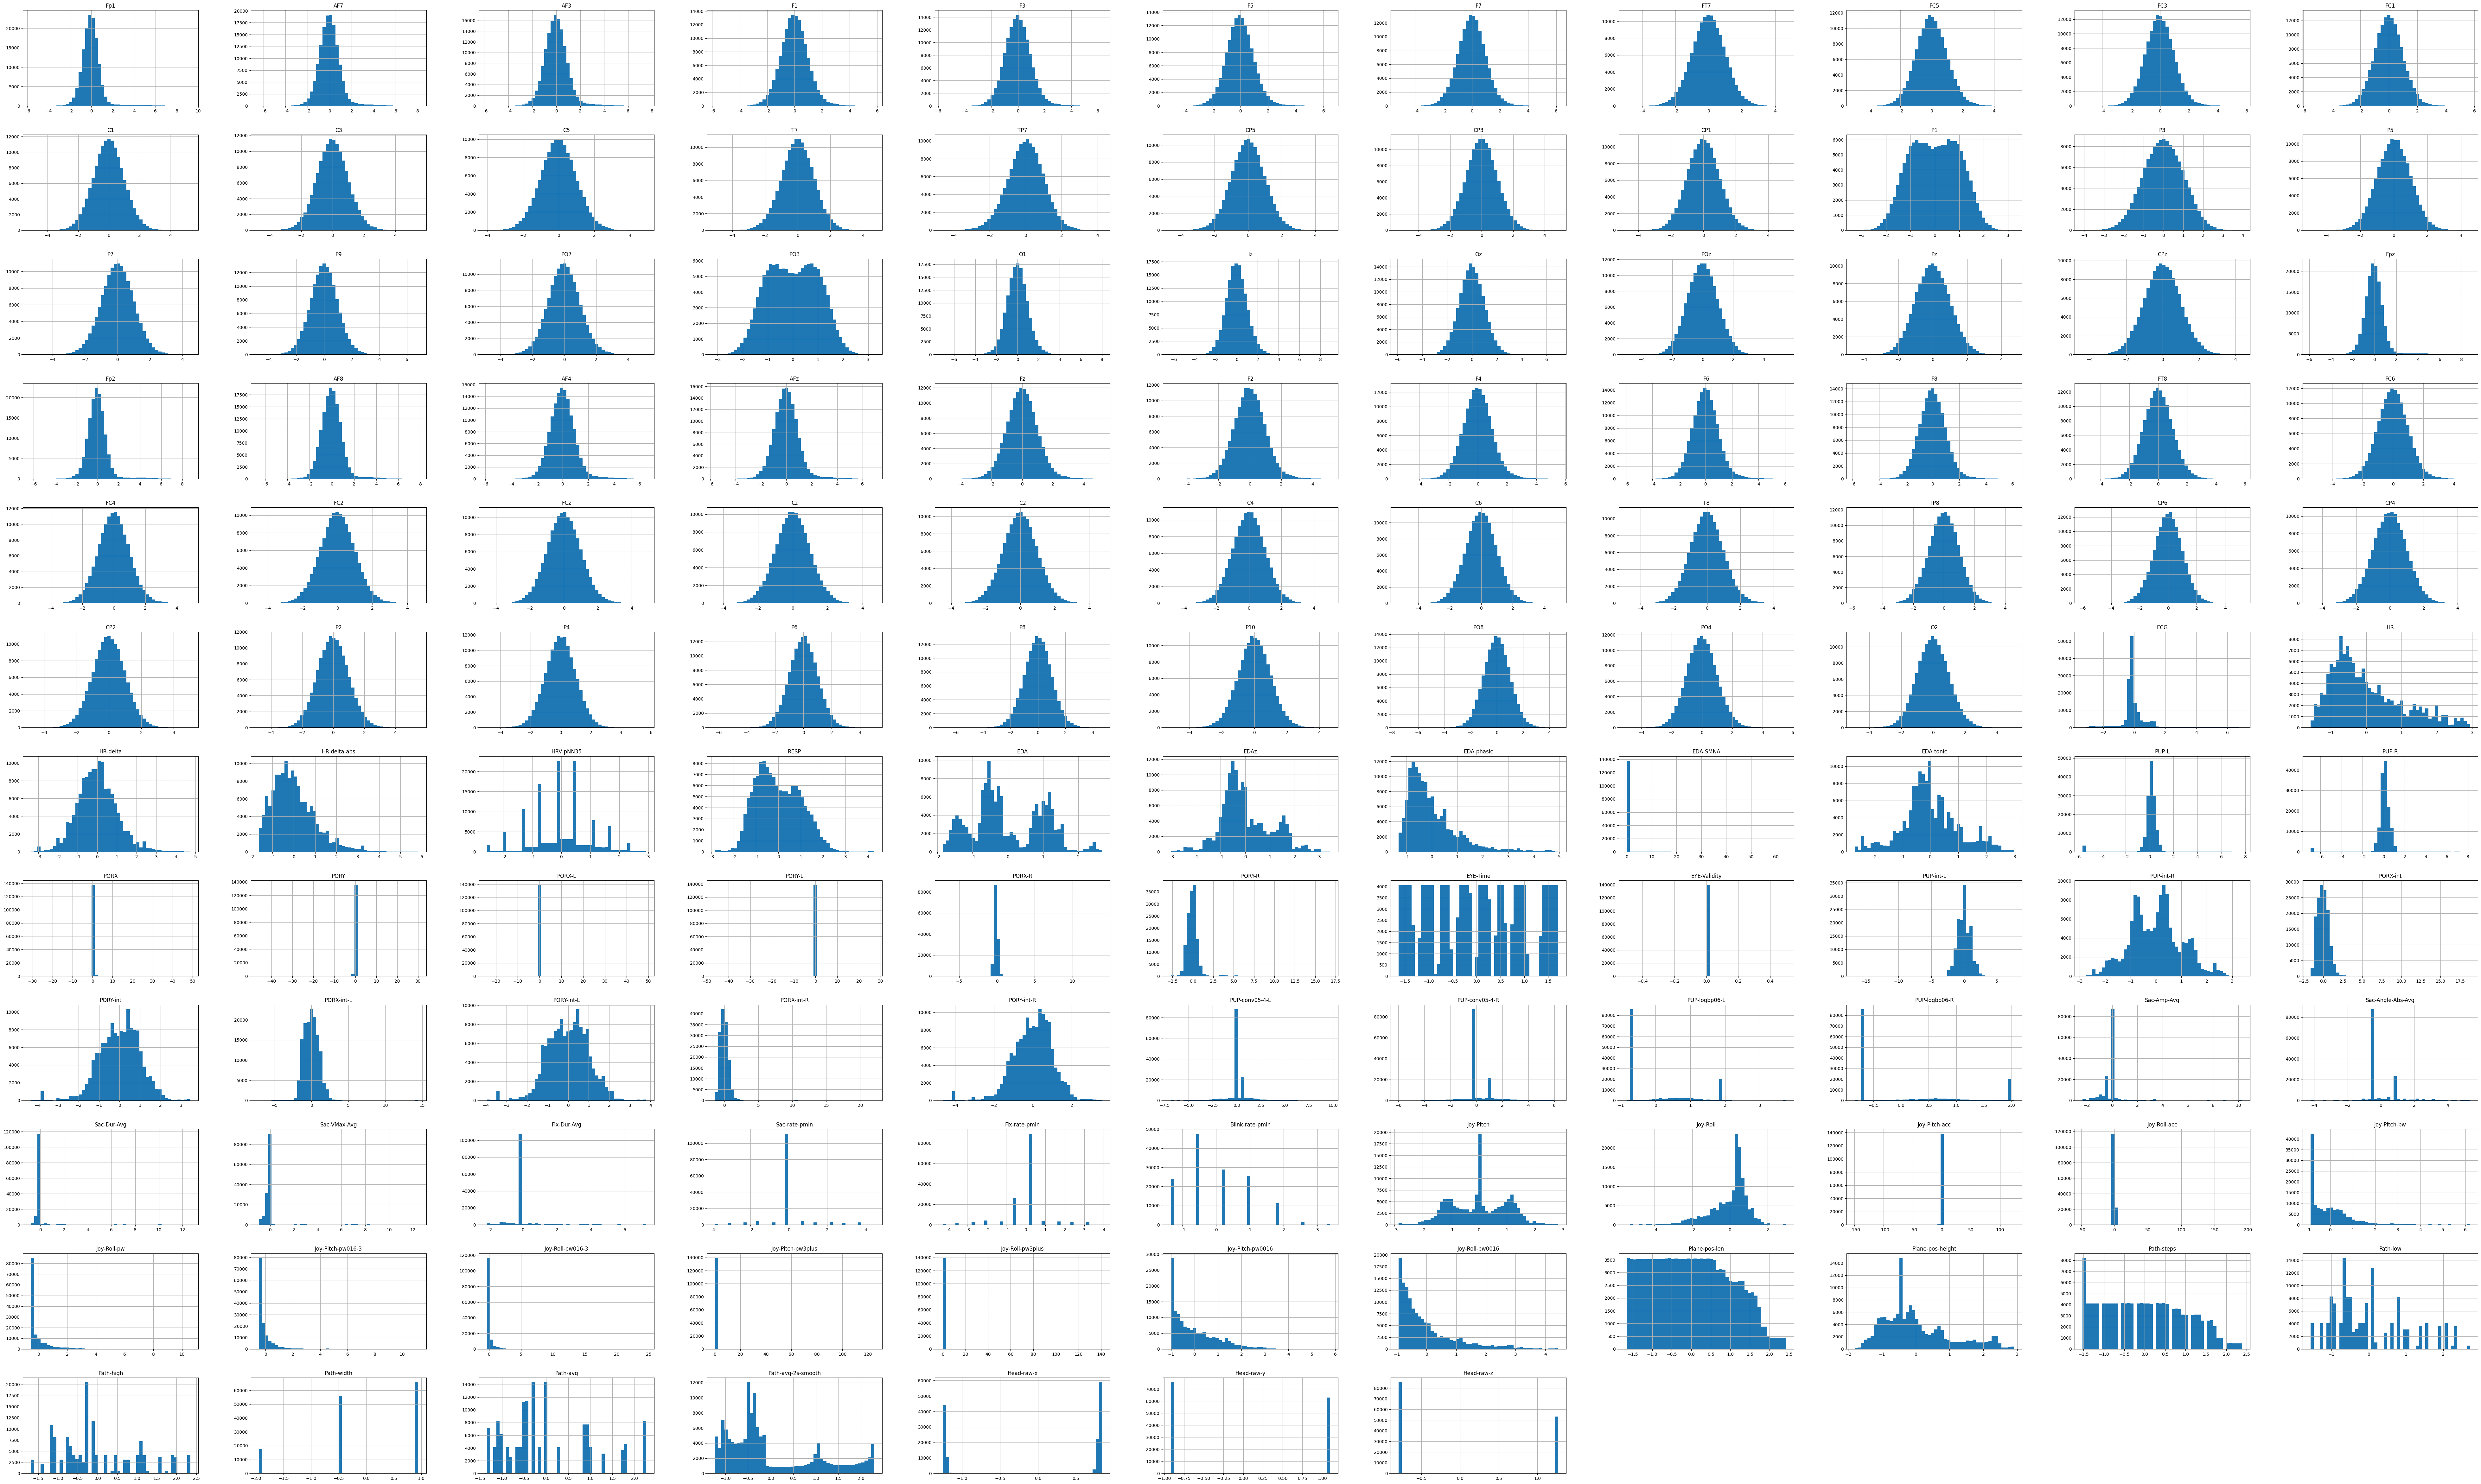

In [16]:
df_open.hist(figsize=(100, 60), bins=50)
plt.title("Histogram for open loop")

plt.show()


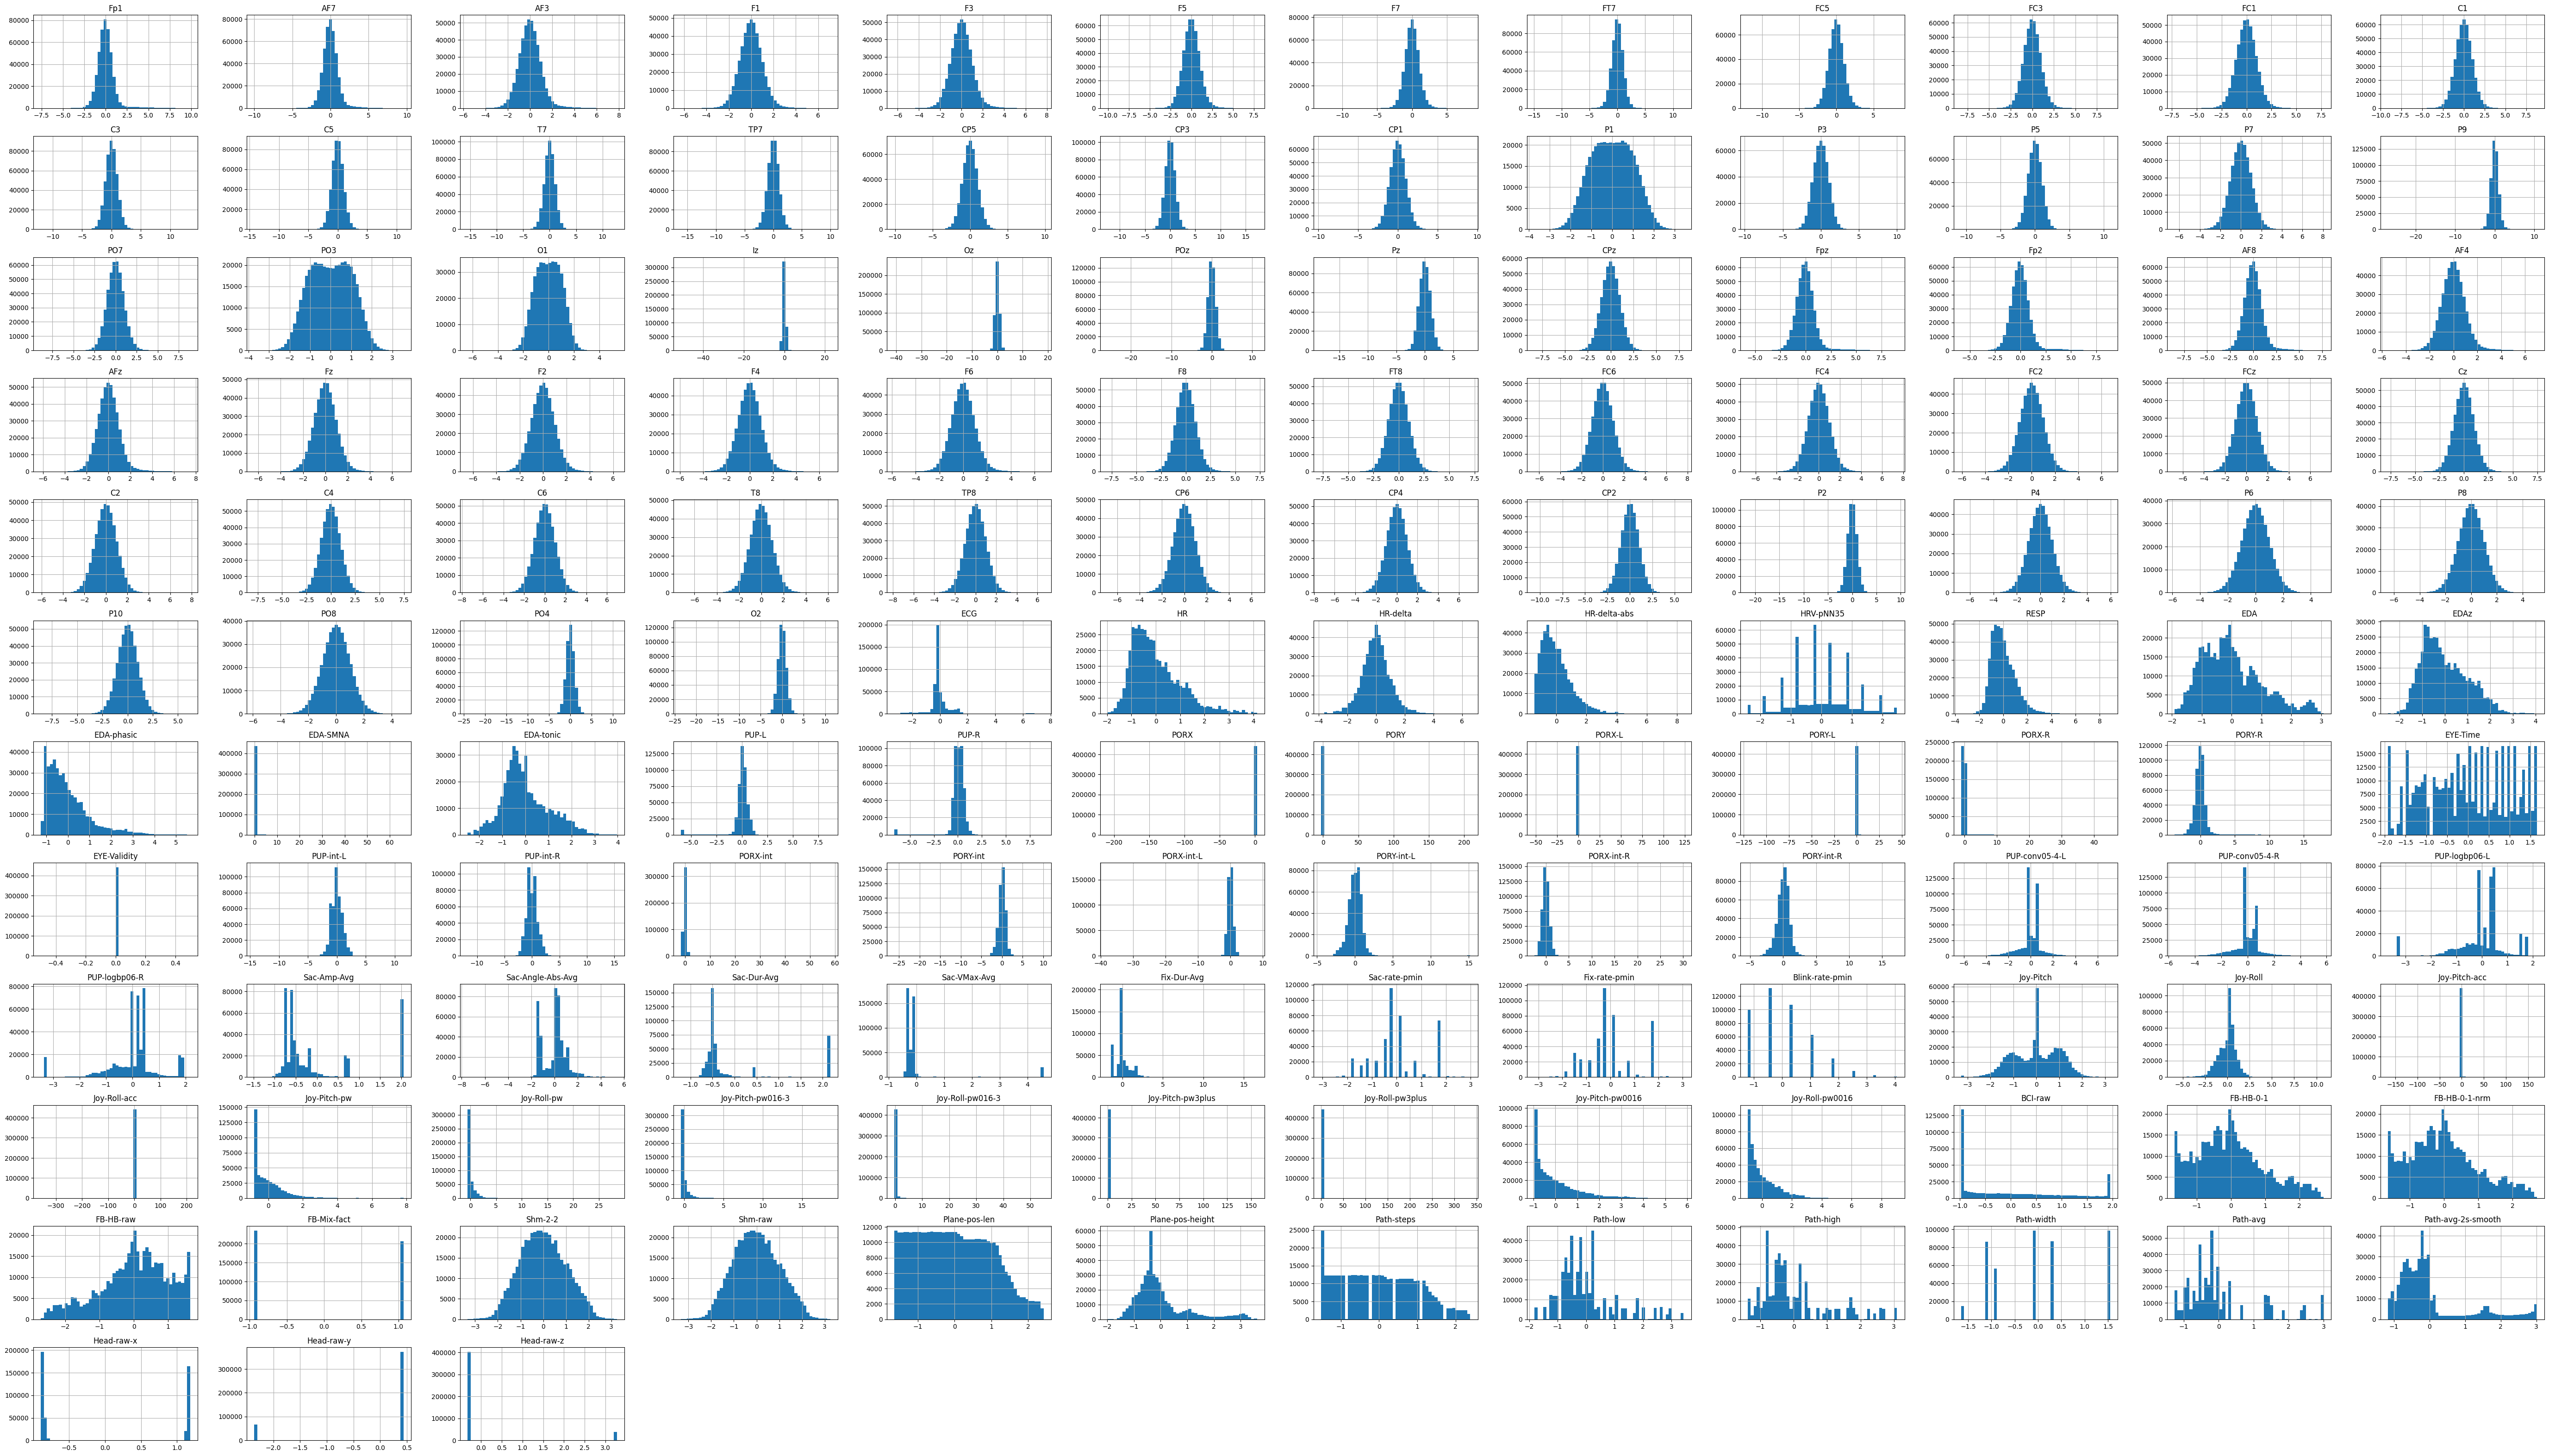

In [17]:
df_closed.hist(figsize=(70, 40), bins=50)
plt.title("Histogram for closed loop")

plt.show()


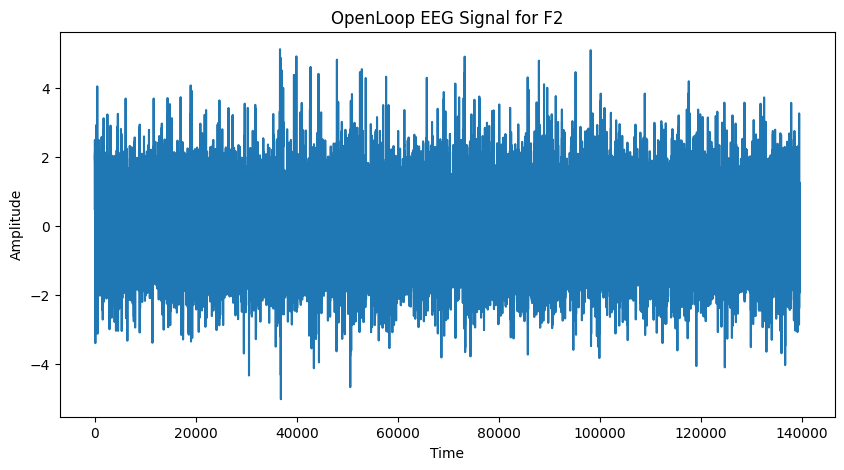

In [18]:

plt.figure(figsize=(10, 5))
plt.plot(df_open["F2"])  # Replace with an actual channel name
plt.title("OpenLoop EEG Signal for F2")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


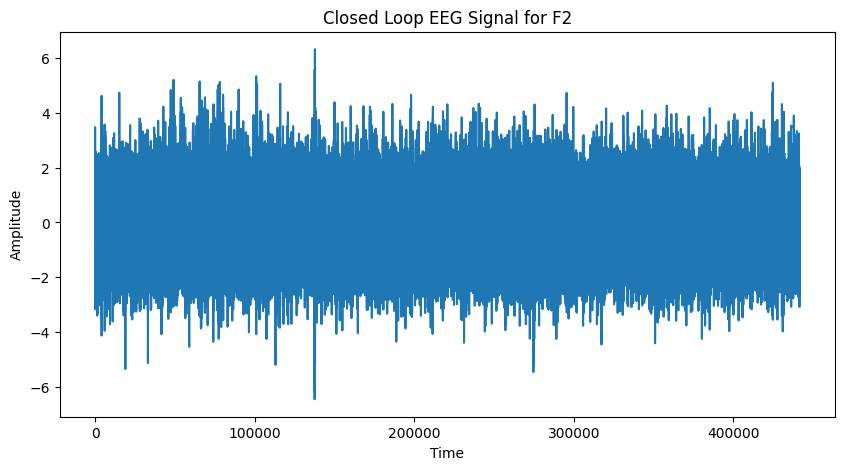

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df_closed["F2"])  # Replace with an actual channel name
plt.title("Closed Loop EEG Signal for F2")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


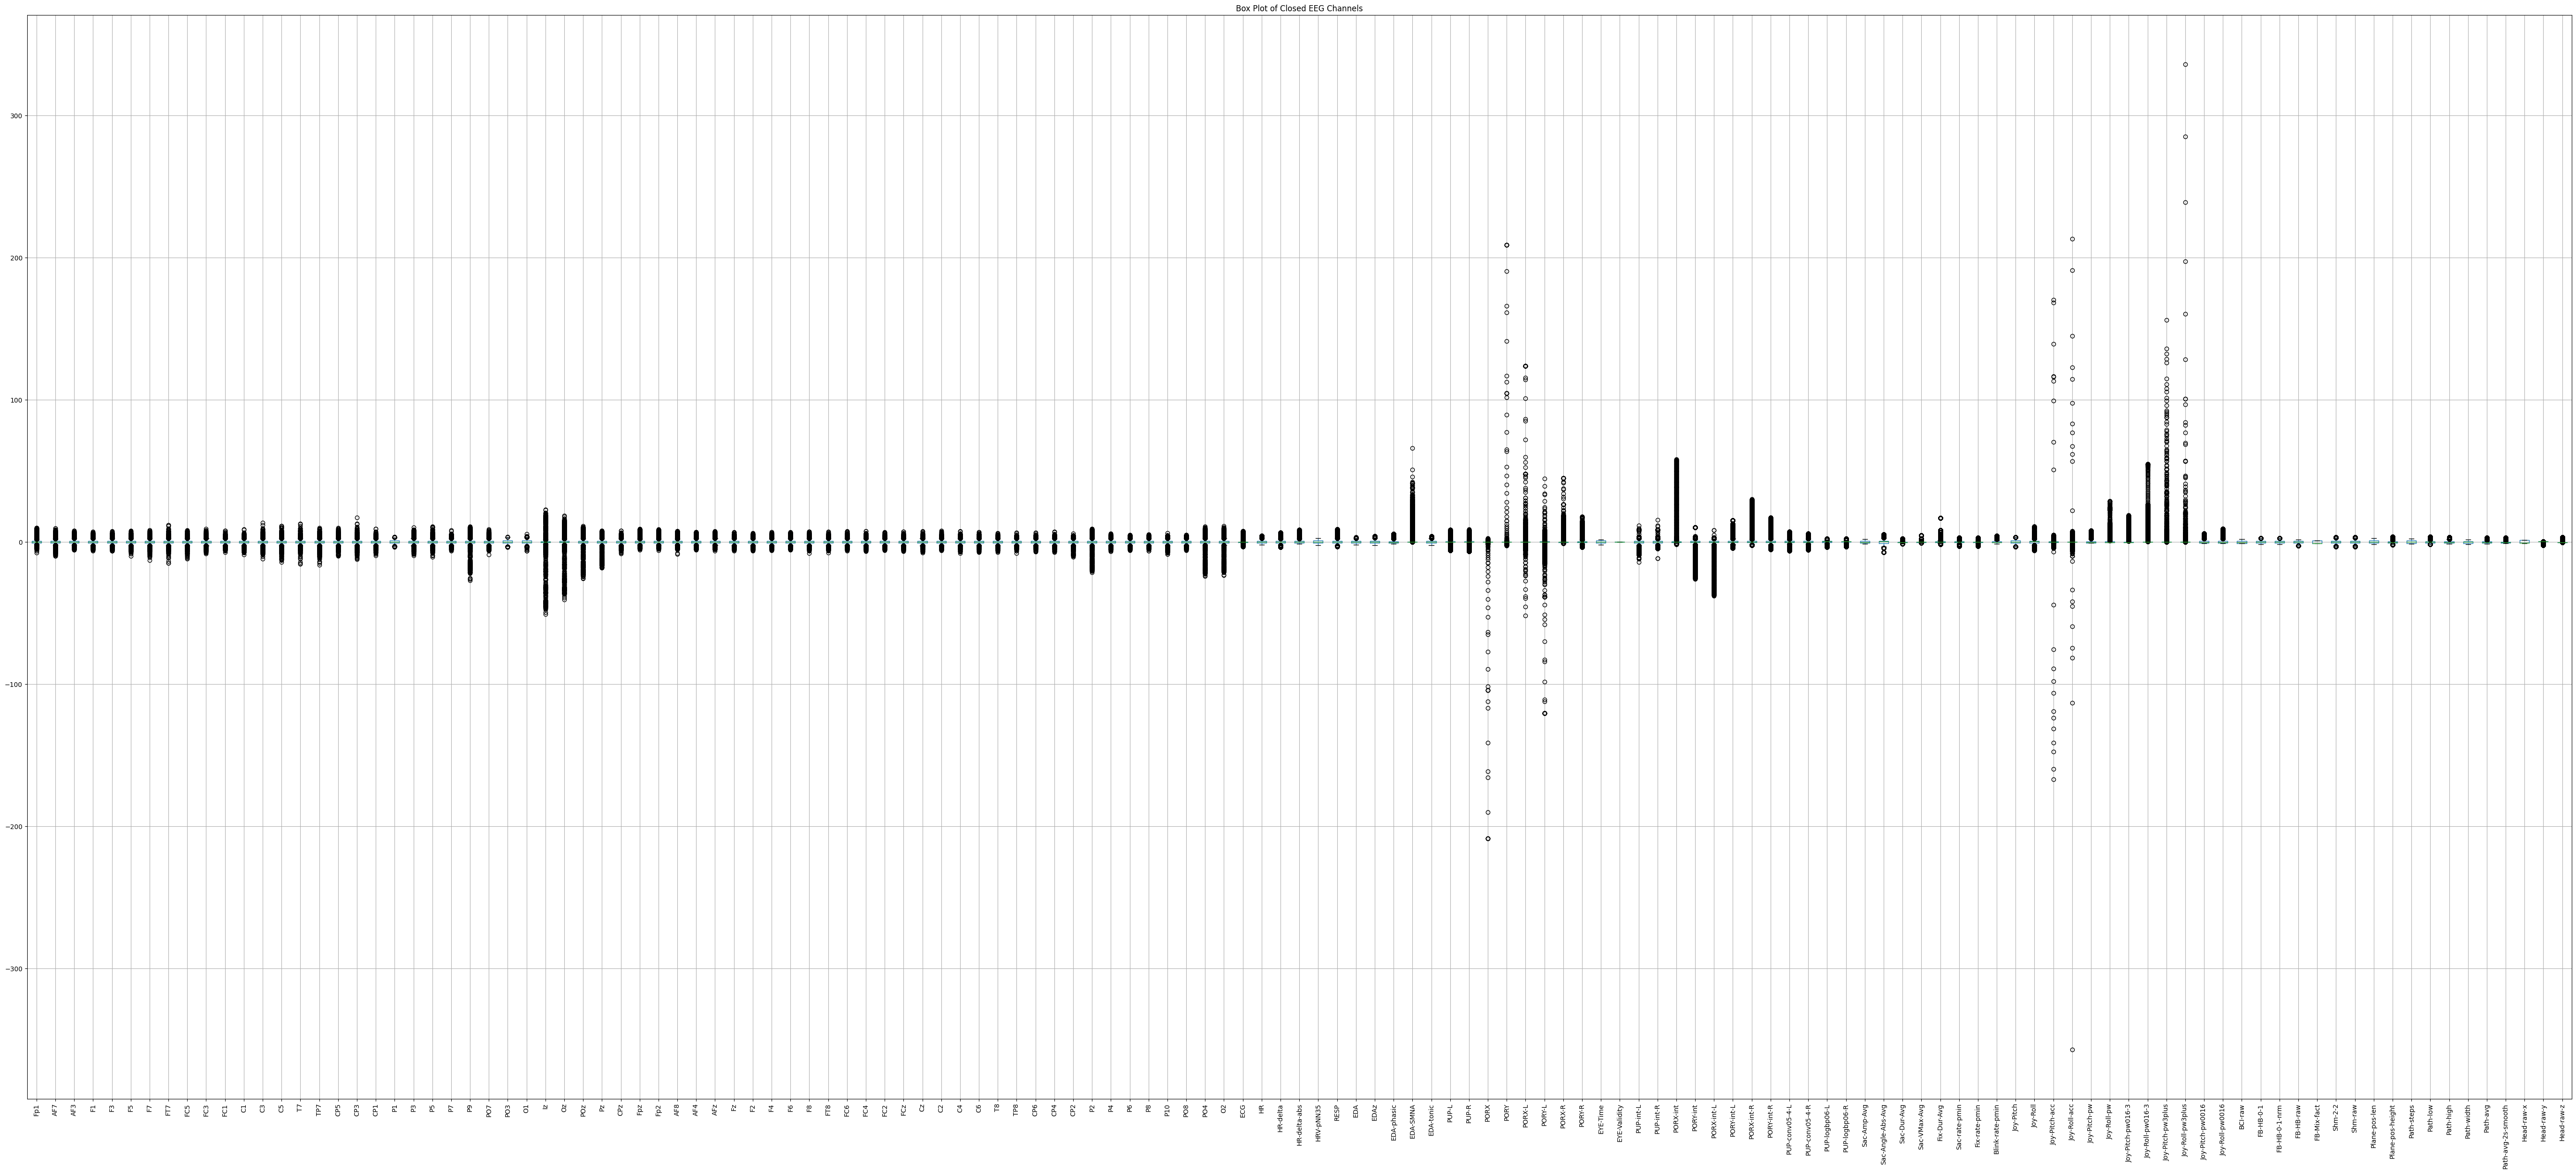

In [20]:
df_closed.boxplot(figsize=(70, 30))
plt.title("Box Plot of Closed EEG Channels")
plt.xticks(rotation=90)
plt.show()


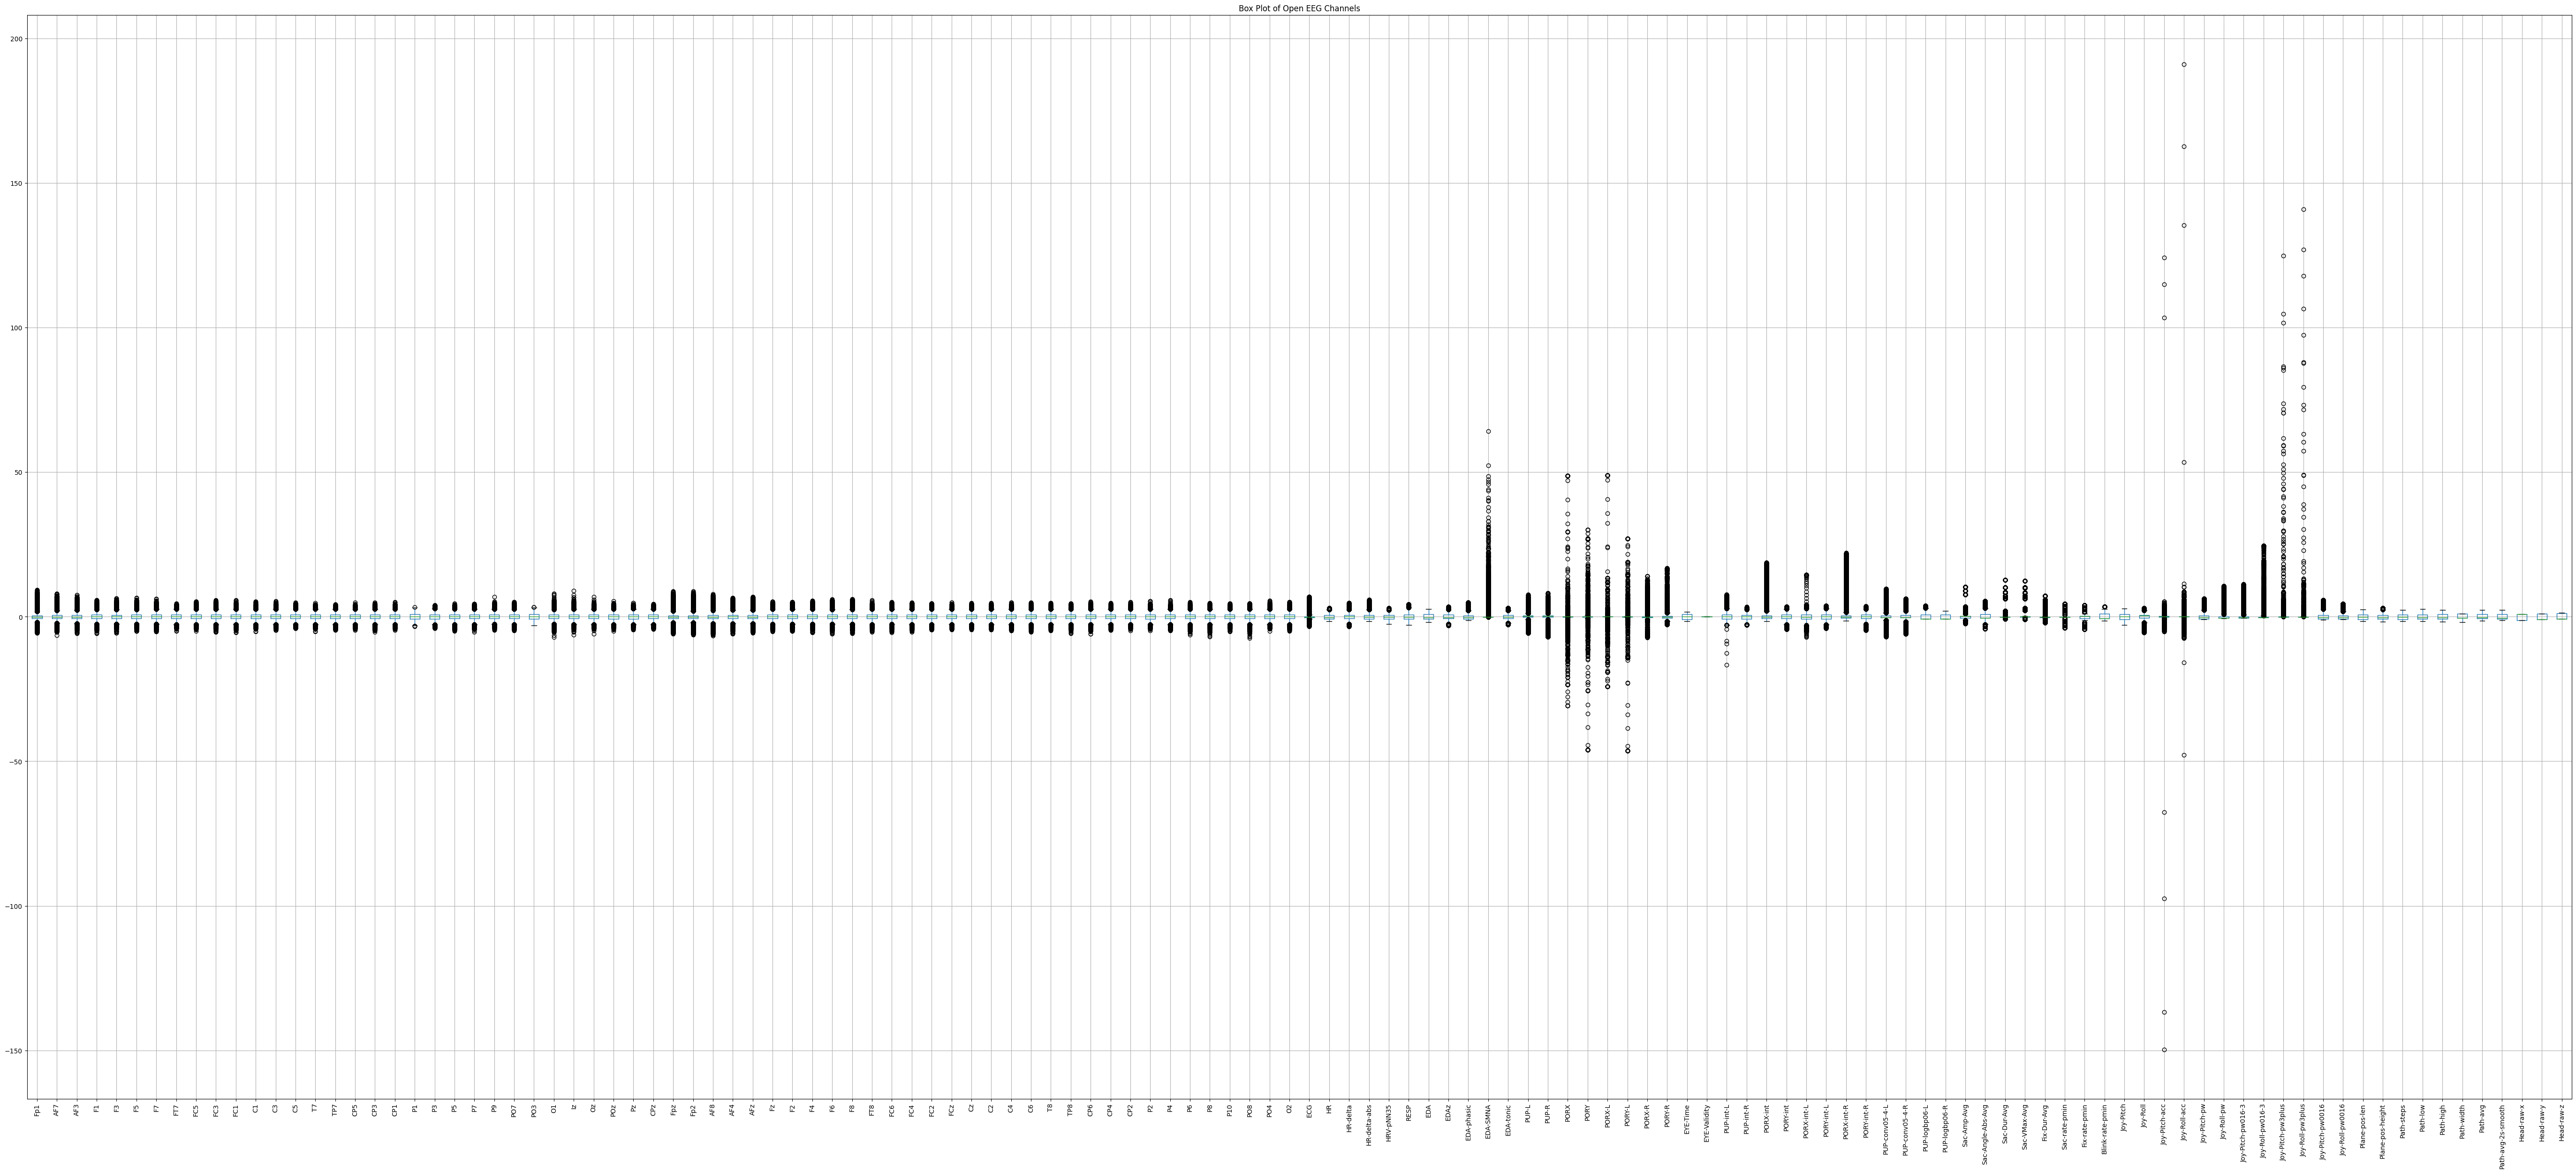

In [21]:
df_open.boxplot(figsize=(70, 30))
plt.title("Box Plot of Open EEG Channels")
plt.xticks(rotation=90)
plt.show()


<ipython-input-22-81351f8a522a>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_closed["O2"], shade=True)  # Replace with actual channel
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


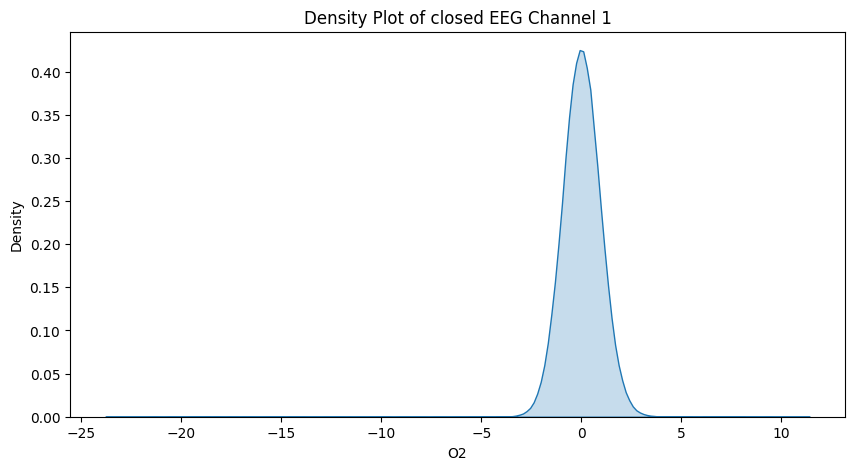

In [22]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(df_closed["O2"], shade=True)  # Replace with actual channel
plt.title("Density Plot of closed EEG Channel 1")
plt.show()


<ipython-input-23-c621cd49e22c>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_open["O2"], shade=True)  # Replace with actual channel
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


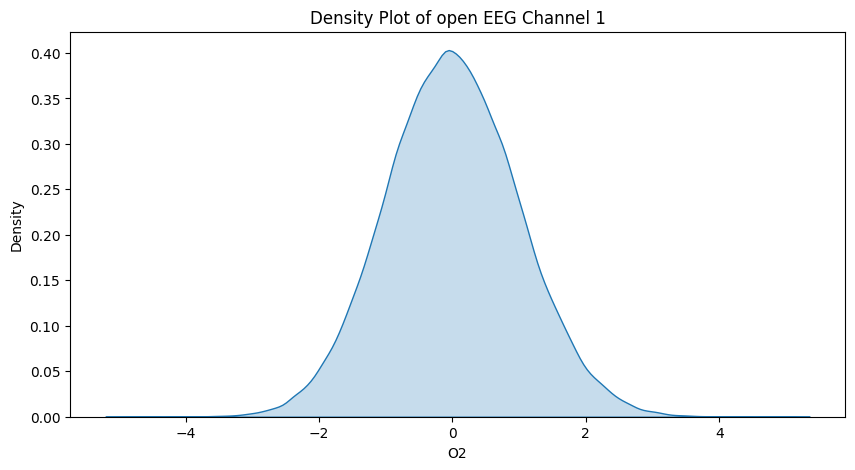

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(df_open["O2"], shade=True)  # Replace with actual channel
plt.title("Density Plot of open EEG Channel 1")
plt.show()


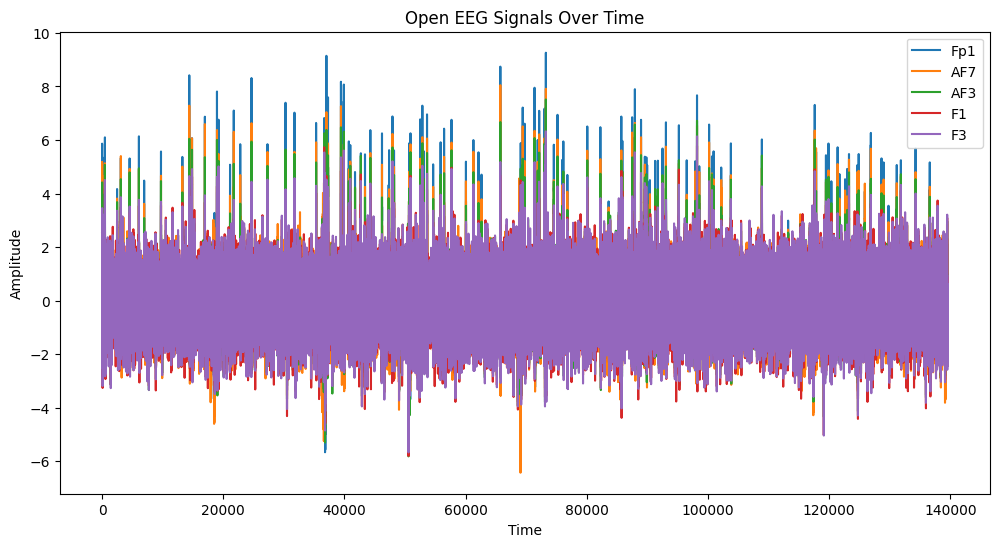

In [24]:
df_open.iloc[:, :5].plot(figsize=(12, 6))  # First 5 channels
plt.title("Open EEG Signals Over Time")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


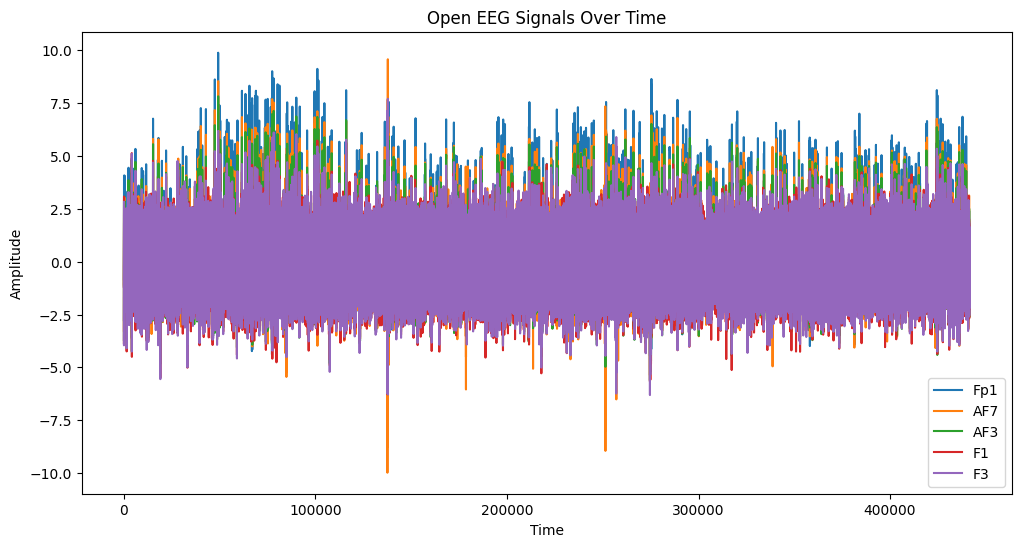

In [25]:
df_closed.iloc[:, :5].plot(figsize=(12, 6))  # First 5 channels
plt.title("Open EEG Signals Over Time")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


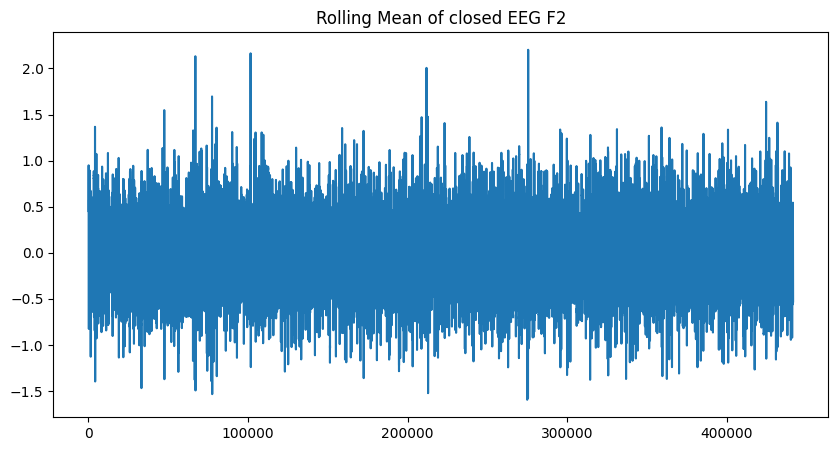

In [26]:
df_closed["F2"].rolling(window=100).mean().plot(figsize=(10, 5))
plt.title("Rolling Mean of closed EEG F2")
plt.show()


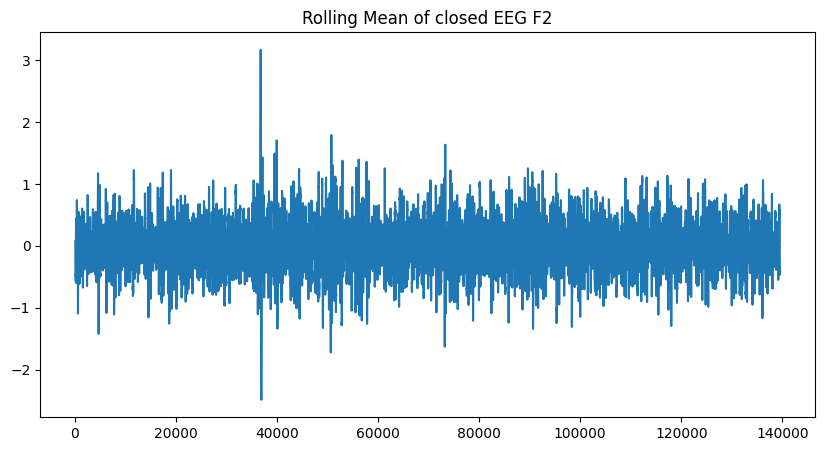

In [27]:
df_open["F2"].rolling(window=100).mean().plot(figsize=(10, 5))
plt.title("Rolling Mean of closed EEG F2")
plt.show()


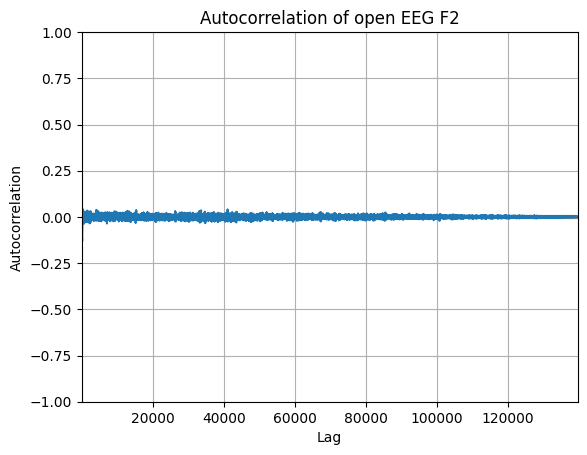

In [28]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_open["F2"])
plt.title("Autocorrelation of open EEG F2")
plt.show()

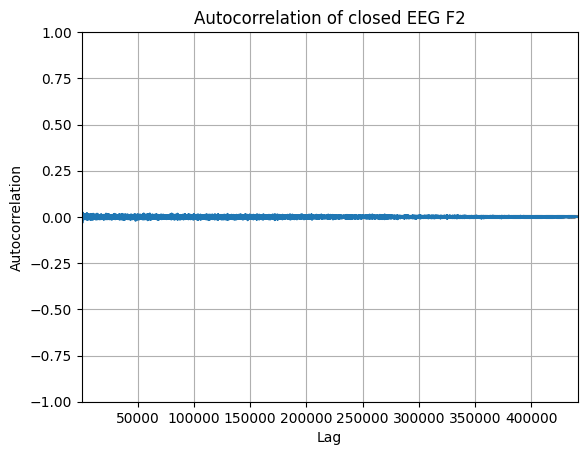

In [29]:
autocorrelation_plot(df_closed["F2"])
plt.title("Autocorrelation of closed EEG F2")
plt.show()

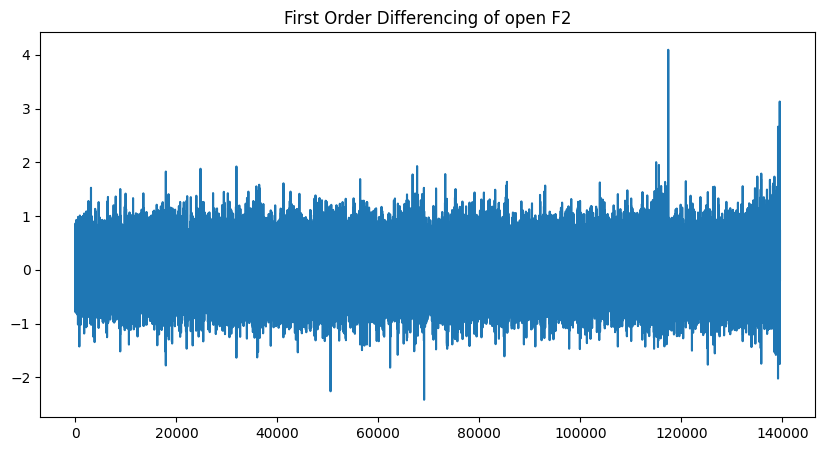

In [30]:
df_open["F2"].diff().plot(figsize=(10, 5))
plt.title("First Order Differencing of open F2")
plt.show()

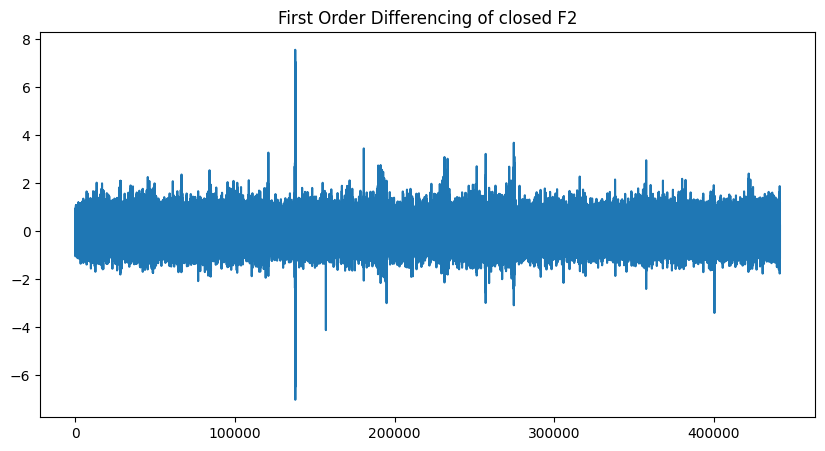

In [31]:
df_closed["F2"].diff().plot(figsize=(10, 5))
plt.title("First Order Differencing of closed F2")
plt.show()

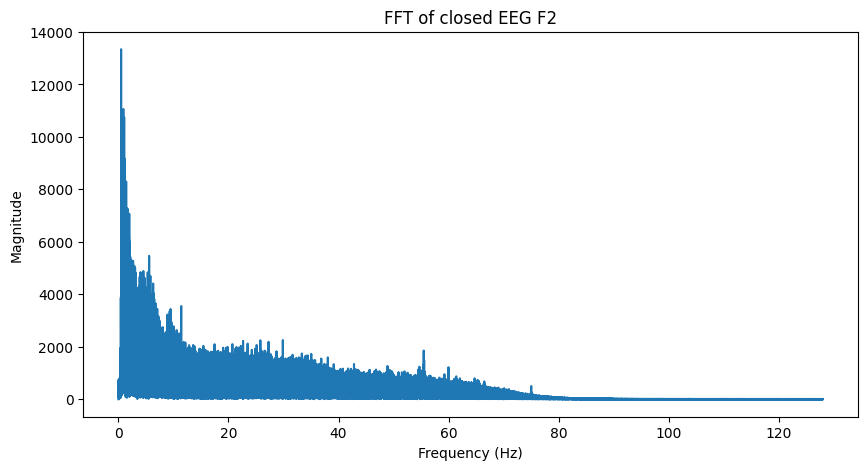

In [32]:
import numpy as np

fs = 256  # Sampling rate
freqs = np.fft.fftfreq(len(df_closed), 1/fs)
fft_values = np.fft.fft(df_closed["F2"])

plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_values)[:len(fft_values)//2])
plt.title("FFT of closed EEG F2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()



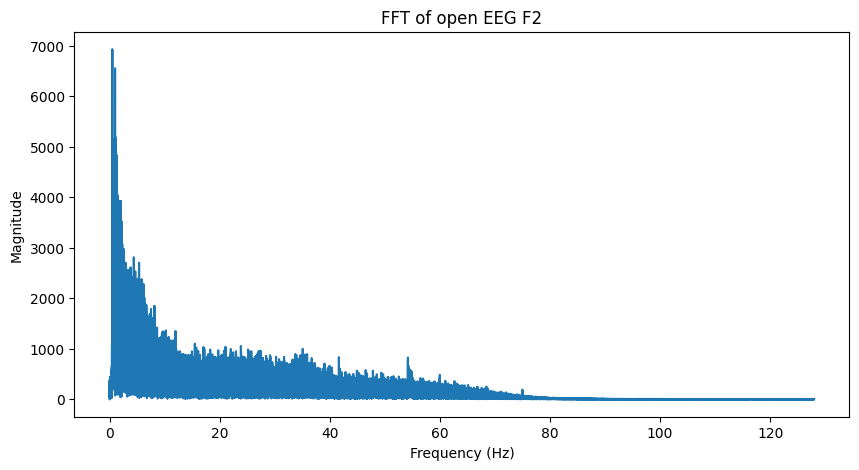

In [33]:
import numpy as np

fs = 256  # Sampling rate
freqs = np.fft.fftfreq(len(df_open), 1/fs)
fft_values = np.fft.fft(df_open["F2"])

plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_values)[:len(fft_values)//2])
plt.title("FFT of open EEG F2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()



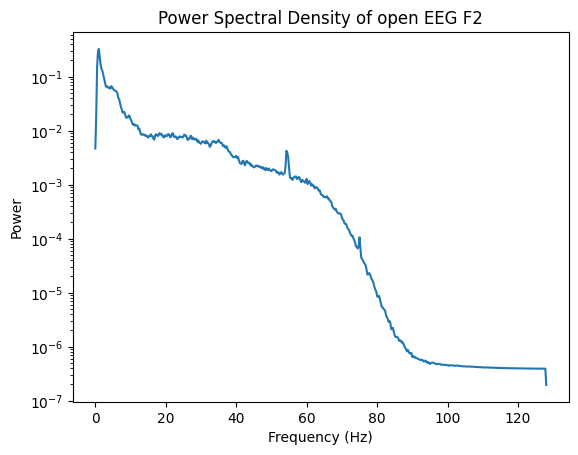

In [34]:
from scipy.signal import welch

frequencies, power = welch(df_open["F2"], fs=256, nperseg=1024)

plt.semilogy(frequencies, power)
plt.title("Power Spectral Density of open EEG F2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()


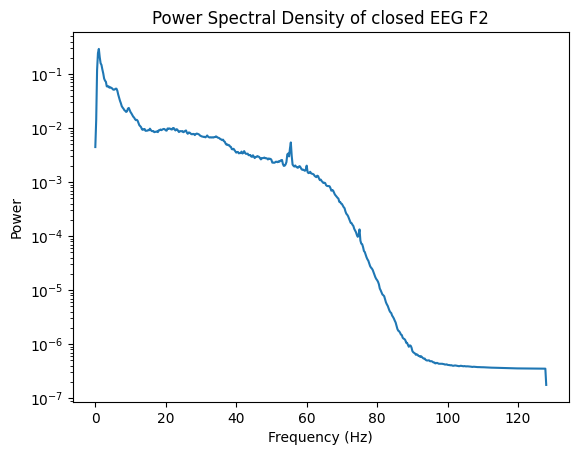

In [35]:
frequencies, power = welch(df_closed["F2"], fs=256, nperseg=1024)

plt.semilogy(frequencies, power)
plt.title("Power Spectral Density of closed EEG F2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()


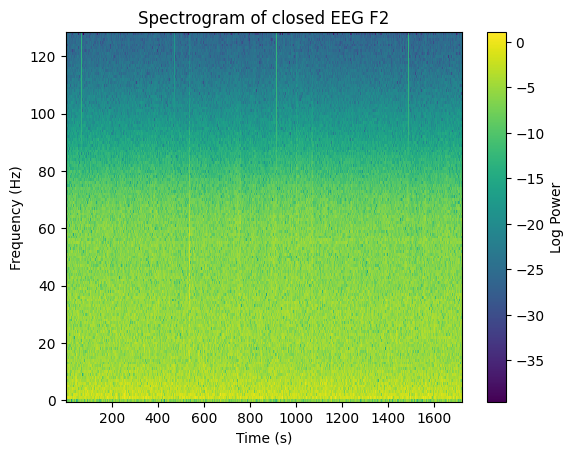

In [36]:
from scipy.signal import spectrogram

frequencies, times, Sxx = spectrogram(df_closed["F2"], fs=256)

plt.pcolormesh(times, frequencies, np.log(Sxx))
plt.title("Spectrogram of closed EEG F2")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Log Power")
plt.show()


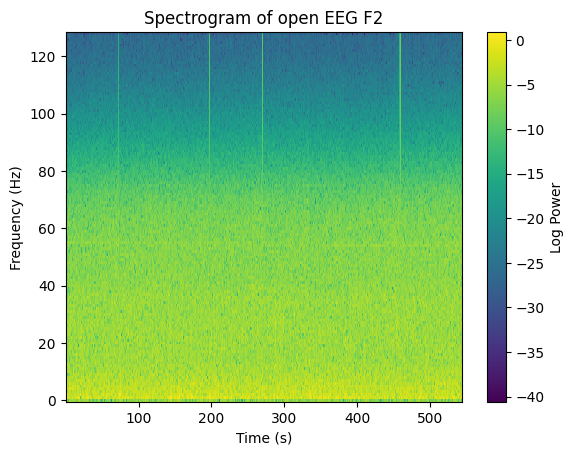

In [37]:
frequencies, times, Sxx = spectrogram(df_open["F2"], fs=256)

plt.pcolormesh(times, frequencies, np.log(Sxx))
plt.title("Spectrogram of open EEG F2")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Log Power")
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


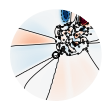

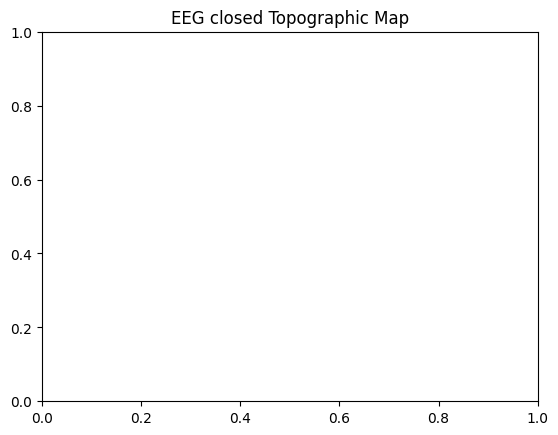

In [38]:
import mne

# Assuming df contains EEG channels only
mne.viz.plot_topomap(df_closed.mean(axis=0), pos=np.random.rand(df_closed.shape[1], 2))
plt.title("EEG closed Topographic Map")
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


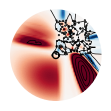

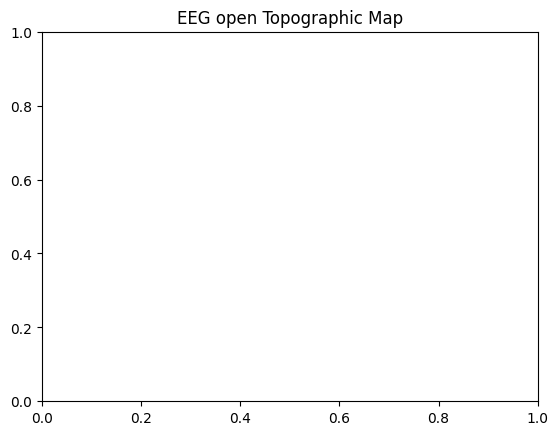

In [39]:
# Assuming df contains EEG channels only
mne.viz.plot_topomap(df_open.mean(axis=0), pos=np.random.rand(df_open.shape[1], 2))
plt.title("EEG open Topographic Map")
plt.show()


/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


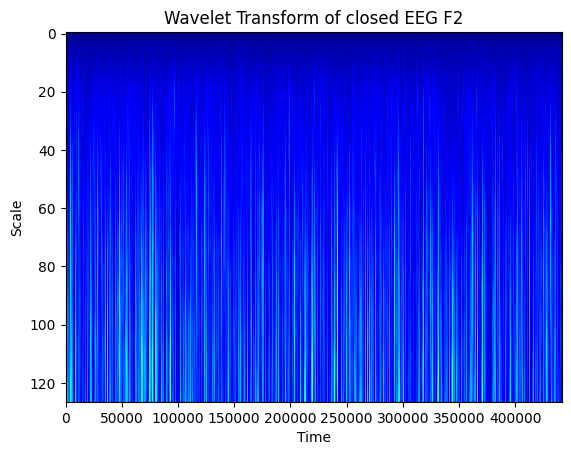

In [40]:
import pywt

coeffs, freqs = pywt.cwt(df_closed["F2"], np.arange(1, 128), "cmor")

plt.imshow(np.abs(coeffs), aspect="auto", cmap="jet")
plt.title("Wavelet Transform of closed EEG F2")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.show()


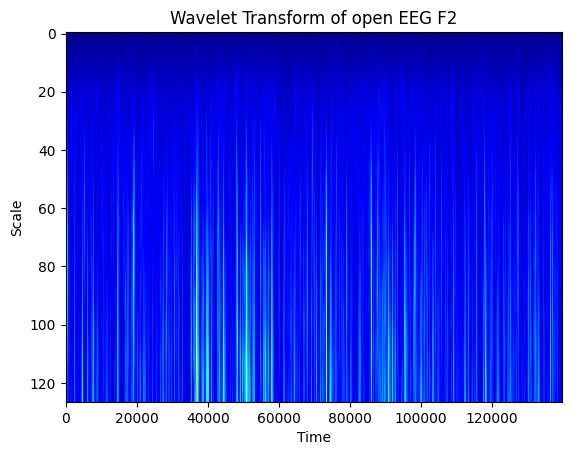

In [41]:
coeffs, freqs = pywt.cwt(df_open["F2"], np.arange(1, 128), "cmor")

plt.imshow(np.abs(coeffs), aspect="auto", cmap="jet")
plt.title("Wavelet Transform of open EEG F2")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.show()

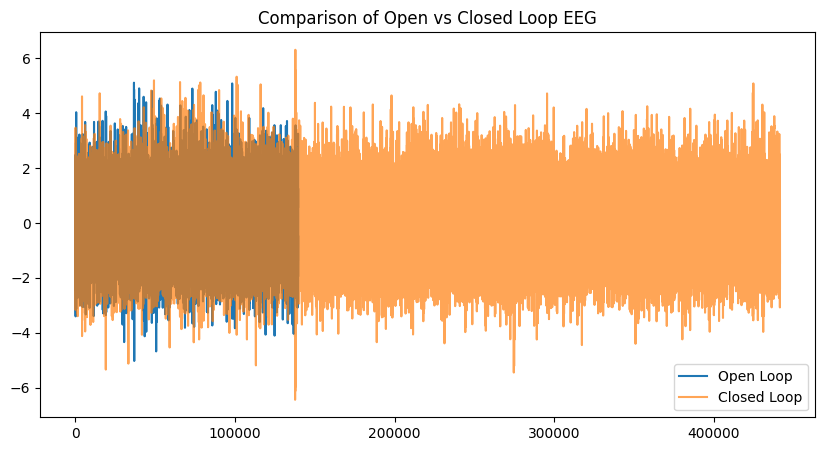

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(df_open["F2"], label="Open Loop")
plt.plot(df_closed["F2"], label="Closed Loop", alpha=0.7)
plt.legend()
plt.title("Comparison of Open vs Closed Loop EEG")
plt.show()


In [43]:
# import os
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Initialize Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Define your folder paths and dataset details
# output_folder_C_OLoop = "csv_C_OLoop"  # Folder containing CSV files for C_OLoop
# output_folder_CL_Sil_50_100 = "csv_CL_Sil_50_100"  # Folder containing CSV files for CL_Sil_50_100

# # Define the dataset metadata
# dataset_title = "Arousal_EEG_Dataset"
# dataset_slug = "arousal-eeg-dataset"
# dataset_description = "This dataset contains EEG data files for arousal classification."

# # Create a temporary folder for the dataset (if needed)
# temp_folder = "arousal_eeg_dataset"
# os.makedirs(temp_folder, exist_ok=True)

# # Move the CSV folders to the temporary folder (for easier upload)
# os.makedirs(os.path.join(temp_folder, "C_OLoop"), exist_ok=True)
# os.makedirs(os.path.join(temp_folder, "CL_Sil_50_100"), exist_ok=True)

# # Copy the CSV files to the respective subfolders
# for file in os.listdir(output_folder_C_OLoop):
#     if file.endswith(".csv"):
#         file_path = os.path.join(output_folder_C_OLoop, file)
#         os.rename(file_path, os.path.join(temp_folder, "C_OLoop", file))

# for file in os.listdir(output_folder_CL_Sil_50_100):
#     if file.endswith(".csv"):
#         file_path = os.path.join(output_folder_CL_Sil_50_100, file)
#         os.rename(file_path, os.path.join(temp_folder, "CL_Sil_50_100", file))

# # Upload the dataset to Kaggle
# api.dataset_create_new(
#     folder_path=temp_folder,  # Path to the temporary folder
#     title=dataset_title,
#     slug=dataset_slug,
#     description=dataset_description,
#     category='Research',
#     is_private=False  # Set to True if you want it to be a private dataset
# )

# print("Dataset upload to Kaggle successful!")


In [44]:
# # Check for NaN or infinite values
# print("Missing values:", np.isnan(eeg_data).sum())
# print("Infinite values:", np.isinf(eeg_data).sum())

### Sampling rate

In [45]:

# sampling_rate = mat_data['actualVariable']['EEG_full']['srate'][()]
# print("Sampling Rate:", sampling_rate)


In [46]:
# import h5py
# import numpy as np
# import pandas as pd
# import os
# import matplotlib.pyplot as plt

# # Define the directory containing the .mat files
# data_dir = "/kaggle/input/arousal/"

# # Get all .mat files in the directory
# file_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".mat")]

# # Dictionary to store time of flight data for plotting
# time_of_flight_dict = {}

# for file_path in file_paths:
#     # Load the .mat file
#     mat_data = h5py.File(file_path, 'r')

#     # Navigate to the correct dataset structure
#     if 'actualVariable' in mat_data:
#         actual_var = mat_data['actualVariable']
        
#         # Check if 'EEG_full' exists
#         if 'EEG_full' in actual_var:
#             eeg_data = actual_var['EEG_full']
            
#             # Compute time of flight: dataset size / 250
#             time_of_flight = eeg_data.shape[1] / 250  
            
#             # Extract subject ID from filename (e.g., "S01_C_OLoop.mat" -> "S01")
#             subject_id = os.path.basename(file_path).split("_")[0]
            
#             # Store the computed time of flight
#             time_of_flight_dict[subject_id] = time_of_flight
#         else:
#             print(f"'EEG_full' not found in {file_path}")
#     else:
#         print(f"'actualVariable' not found in {file_path}")

# # Convert dictionary to DataFrame for further analysis
# df_time_of_flight = pd.DataFrame(list(time_of_flight_dict.items()), columns=["Subject", "Time_of_Flight"])

# # Display the DataFrame
# print(df_time_of_flight)

# # Plot the time of flight for each subject
# plt.figure(figsize=(10, 5))
# plt.bar(df_time_of_flight["Subject"], df_time_of_flight["Time_of_Flight"], color="royalblue")

# plt.xlabel("Subject")
# plt.ylabel("Time of Flight (s)")
# plt.title("Time of Flight Across Subjects")
# plt.grid(axis="y", linestyle="--")

# # Save the plot before showing
# plt.savefig("../working/time_of_flight_plot.png", dpi=300)
# plt.show()


In [47]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df_cleaned is your DataFrame with EEG data
# # List of EEG channel names
# channels = df_cleaned['Channel'].tolist()

# # Select only the EEG channels and the time column (if applicable)
# time_column = eeg_data.index  # Assuming the index is the time or you could use a specific column if you have a 'time' column.
# eeg_data = eeg_data[channels]

# # Plot all EEG waveforms on the same graph
# plt.figure(figsize=(12, 8))

# for channel in channels:
#     plt.plot(time_column, eeg_data[channel], label=channel)

# # Add labels and title
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('EEG Waveforms for All Channels')
# plt.grid(True)

# # Add a legend to differentiate the channels
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.savefig("waveforms.png")
# plt.show()

In [48]:
# from scipy import signal
# import matplotlib.pyplot as plt

# # Example for a single channel
# fs = 256  # Sampling frequency
# f, t, Sxx = signal.spectrogram(eeg_data['C3'], fs)
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogram for C3')
# plt.colorbar(label='Intensity [dB]')
# plt.savefig("spectogram_c3.png")
# plt.show()

In [49]:
# from scipy import signal
# import matplotlib.pyplot as plt

# # Example for a single channel
# f, Pxx = signal.welch(eeg_data['C3'], fs=250, nperseg=1024)
# plt.semilogy(f, Pxx)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Power Spectral Density [V**2/Hz]')
# plt.title('Power Spectral Density for C3')
# plt.grid(True)
# plt.show()

In [50]:
# import mne
# import numpy as np

# # Example data
# data = np.random.randn(64)  # Example data for 32 channels
# info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
# evoked = mne.EvokedArray(data[:, np.newaxis], info)

# # Plot topographic map
# evoked.plot_topomap(times=[0], size=3, show=True)

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# # Example for a single channel
# t = np.linspace(0, 1, 500, endpoint=False)
# sig = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
# frequencies, times, Sxx = signal.spectrogram(sig, fs=250)

# plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Time-Frequency Analysis')
# plt.colorbar(label='Intensity [dB]')
# plt.savefig("Time_frequency.png")
# plt.show()

In [52]:
# import matplotlib.pyplot as plt

# # Example: Averaging across trials for a specific channel
# erp = eeg_data.groupby('event').mean()['C3']
# plt.plot(erp)
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('Event-Related Potential for C3')
# plt.grid(True)
# plt.show()

In [53]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Compute correlation matrix
# corr_matrix = eeg_data.corr()

# # Plot heatmap
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Channel Correlation Heatmap')
# plt.savefig("channel_correlation.png")
# plt.show()

In [54]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot boxplot
# sns.boxplot(data=eeg_data)
# plt.xlabel('Channels')
# plt.ylabel('Amplitude (µV)')
# plt.title('Boxplot of Channel Amplitudes')
# plt.savefig("Boxplot.png")
# plt.show()

In [55]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# # Example data
# X, Y = np.meshgrid(time_column, channels)
# Z = eeg_data.values.T

# # Plot 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# ax.set_xlabel('Time (samples)')
# ax.set_ylabel('Channels')
# ax.set_zlabel('Amplitude (µV)')
# plt.title('3D Surface Plot of EEG Data')
# plt.show()

In [56]:
# # Define paths
# closed_loop_path = '/kaggle/working/csv_CL_Sil_50_100'
# open_loop_path = '/kaggle/working/csv_C_OLoop'

# # Exclude subjects 13 and 14
# excluded_subjects = ['S13', 'S14']

# # Initialize an empty list to store dataframes
# dataframes = []

# # Loop through all files in the closed-loop folder
# for filename in os.listdir(closed_loop_path):
#     # Check if the file is a CSV and not from excluded subjects
#     if filename.endswith('.csv') and not any(subject in filename for subject in excluded_subjects):
#         # Construct the full file path
#         file_path = os.path.join(closed_loop_path, filename)
#         # Read the CSV file
#         df = pd.read_csv(file_path)
#         # Add a column for subject ID
#         df['subject'] = filename.split('_')[0]  # Extract subject ID from filename (e.g., S01)
#         # Append the dataframe to the list
#         dataframes.append(df)

# # Combine all dataframes into one
# combined_data = pd.concat(dataframes, ignore_index=True)

In [57]:
# # Separate features (X) and target (y)
# X = combined_data.drop(columns=['arousal_level', 'subject'])  # Drop target and subject ID
# y = combined_data['arousal_level']  # Target column

# # Normalize/standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Add subject ID back to the scaled data for splitting
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# X_scaled['subject'] = combined_data['subject']

In [58]:

# # Get unique subjects
# subjects = X_scaled['subject'].unique()

# # First split: 70% train, 30% temporary (val + test)
# train_subjects, temp_subjects = train_test_split(subjects, test_size=0.3, random_state=42)

# # Second split: 50% val, 50% test (from the 30% temporary split)
# val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

# # Print the number of subjects in each set
# print(f"Train subjects: {len(train_subjects)}")
# print(f"Validation subjects: {len(val_subjects)}")
# print(f"Test subjects: {len(test_subjects)}")

In [59]:
# # Split the data based on subjects
# X_train = X_scaled[X_scaled['subject'].isin(train_subjects)].drop(columns=['subject'])
# X_val = X_scaled[X_scaled['subject'].isin(val_subjects)].drop(columns=['subject'])
# X_test = X_scaled[X_scaled['subject'].isin(test_subjects)].drop(columns=['subject'])

# y_train = y[X_scaled['subject'].isin(train_subjects)]
# y_val = y[X_scaled['subject'].isin(val_subjects)]
# y_test = y[X_scaled['subject'].isin(test_subjects)]

In [60]:

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def evaluate_model(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = mse ** 0.5
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     return {
#         'MSE': mse,
#         'RMSE': rmse,
#         'MAE': mae,
#         'R²': r2
#     }

# # Initialize the model
# linear_model = LinearRegression()

# # Train the model
# linear_model.fit(X_train, y_train)

# # Predict on the validation set
# y_val_pred = linear_model.predict(X_val)

# # Evaluate the model
# linear_metrics = evaluate_model(y_val, y_val_pred)

# # Print results
# print("Linear Regression (Validation Set):")
# for metric, value in linear_metrics.items():
#     print(f"  {metric}: {value:.4f}")

In [61]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso

# # Initialize models
# models = {
#     'Ridge Regression': Ridge(alpha=1.0),
#     'Lasso Regression': Lasso(alpha=0.01)
# }

# # Train and evaluate models
# results = {}
# for name, model in models.items():
#     # Train the model
#     model.fit(X_train, y_train)
#     # Predict on validation set
#     y_pred = model.predict(X_val)
#     # Evaluate the model
#     results[name] = evaluate_model(y_val, y_pred)

# # Print results
# for name, metrics in results.items():
#     print(f"{name}:")
#     for metric, value in metrics.items():
#         print(f"  {metric}: {value:.4f}")

### Neural network 

In [62]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define the model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
#     Dropout(0.2),  # Dropout for regularization
#     Dense(32, activation='relu'),  # Hidden layer
#     Dropout(0.2),  # Dropout for regularization
#     Dense(16, activation='relu'),  # Hidden layer
#     Dense(1)  # Output layer (no activation for regression)
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# # Print the model summary
# model.summary()

In [63]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=100,  # Maximum number of epochs
#     batch_size=32,  # Adjust based on your dataset size
#     callbacks=[early_stopping],
#     verbose=1
# )

In [64]:
# # Predict on the validation set
# y_val_pred = model.predict(X_val).flatten()

# # Evaluate the model
# nn_metrics = evaluate_model(y_val, y_val_pred)

# # Print results
# print("Neural Network (Validation Set):")
# for metric, value in nn_metrics.items():
#     print(f"  {metric}: {value:.4f}")

In [65]:
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.svm import SVR

# # Add more models
# models.update({
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42),
#     'SVR': SVR(kernel='rbf')
# })

# # Train and evaluate models
# for name, model in models.items():
#     if name not in results:  # Skip already trained models
#         # Train the model
#         model.fit(X_train, y_train)
#         # Predict on validation set
#         y_pred = model.predict(X_val)
#         # Evaluate the model
#         results[name] = evaluate_model(y_val, y_pred)

# # Print results
# for name, metrics in results.items():
#     print(f"{name}:")
#     for metric, value in metrics.items():
#         print(f"  {metric}: {value:.4f}")

In [66]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f"Best parameters: {best_params}")

# # Evaluate the best model on the validation set
# y_pred = best_model.predict(X_val)
# results['Random Forest (Tuned)'] = evaluate_model(y_val, y_pred)

# # Print results
# print("Random Forest (Tuned):")
# for metric, value in results['Random Forest (Tuned)'].items():
#     print(f"  {metric}: {value:.4f}")